In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

# Section 1: Solving Kepler Equations

This section solves the Kepler Equations to establish a baseline for what the N Body code results should look like

In [2]:
def relaxation(f,i,p):
    #arguments of f, the function, i, the initial guess, and p, the precision
    x=i
    num_iters = 0
    while(np.abs(f(x)-x)>p):
        x = f(x)
        num_iters += 1
    return(x,num_iters)

In [3]:
#system variables
m1 = 1
m2 = 1
a = 1
e = 0.5

t_list = np.linspace(0,2*np.pi,100)

def psi(x,t):
    return(np.sqrt(m1+m2/(a**3))*t + e*np.sin(x))

def psidot(xd,x):
    return(np.sqrt(m1+m2/(a**3)) + e*np.cos(x)*xd)

In [4]:
def relax_solve_kepler(t_list,a=a,e=e,m1=m1,m2=m2):
    
    #initializing lists
    psi_list = []
    psidot_list = []
    
    
    for t in t_list:
        #nested functions for each timestep
        def f(x):
            return(psi(x,t))

        psi_step = relaxation(f,0,0.001)[0]
        
        def fdot(xd):
            return(psidot(xd,psi_step))
        
        psidot_step = relaxation(fdot,0,0.001)[0]
        
        psi_list.append(psi_step)
        psidot_list.append(psidot_step)
        
    return(psi_list,psidot_list)

In [5]:
p,pd = relax_solve_kepler(t_list,a,e,m1,m2)

In [6]:
#defining position and velocity
def r(psi,a=a,e=e):
    return(a*(1-e*np.cos(psi)))

def rd(psi,psidot,a=a,e=e):
    return(a*e*np.sin(psi)*psidot)


In [7]:
#constructing numpy arrays in order to get r's and rd's
p = np.array(p)
pd = np.array(pd)

r_list = r(p)
rd_list = rd(p,pd)

Text(0.5, 1.0, 'Solution of Kepler Equations')

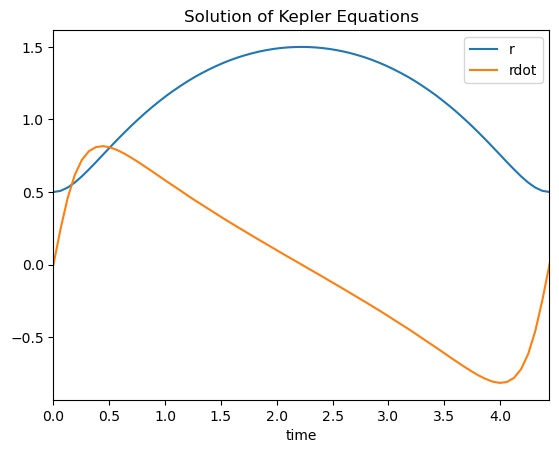

In [8]:
plt.plot(t_list,r_list)
plt.plot(t_list,rd_list)
plt.legend(("r","rdot"))
plt.xlabel("time")
plt.xlim((0,2*np.pi/(np.sqrt(2))))
plt.title("Solution of Kepler Equations")
#plt.savefig("Glaze_2Body_Kepler.pdf")

# Section 2: N Body

OooOOoooo scaaarry

In [59]:
def GenerateIC(num_particles,rmax=5,vmax=5,mmax=5):
    #generates random ICs for specified number of particles with specified
    #    maximum position and velocities
    
    r_list = []
    #this r_list is [x,y,z,vx,vy,vz,m]
    
    for i in range(num_particles):
        r = []
        #generates 3 random values for the position
        r.append(np.random.rand()*rmax)
        r.append(np.random.rand()*rmax)
        r.append(np.random.rand()*rmax)
        #and 3 random values for the velocity
        r.append(np.random.rand()*vmax)
        r.append(np.random.rand()*vmax)
        r.append(np.random.rand()*vmax)
        #and a randomized mass
        r.append(np.random.rand()*mmax)
        #appends vector to r_list, which will be output
        r_list.append(r)
    return(r)


def NBody(initial_rs,tfinal):
    num_particles = len(initial_rs)
    G = 1 #by judicial choice of units, we define G=1
    
    #constructing lists of masses and coords
    r_list = []
    m_list = []
    t_list = []
    #initializing output lists:
    t = 0
    t_list.append(t)
    output_list = []
#     for i in range(num_particles):
#         #outputs will be (p1,p2,....)
#         # with p1, etc. being lists of [[x's],[y's],[z's],[vx's],[vy's],[vz's]]
#         output_list.append([[],[],[],[],[],[]])
    
    for i in initial_rs:
        r_list.append(i[0:-1])
        m_list.append(i[-1])
    
    while t<tfinal:
        
        #define time step:
        #    calc mass density:
        #p = pass
        #dt = 3/np.sqrt(G*p)

        #temporary solution:
        dt = 0.01
        
        #call integrator:
        new_r = favODE(r_list,m_list,t,dt)
        t = t_list[-1]+dt
        
        t_list.append(t)
        r_list = new_r
        output_list.append(new_r)
    
    return(output_list)


def GravityEquations(r,r_list,m_list):
    #takes input particles, outputs acceleration due to gravity of other particles
    
    G = 1 #by judicial choice of units, we define G=1

    def ax(t,ri):
        a = 0
        
        for j in range(len(r_list)):
            rj = r_list[j]
            if rj != r:
                #only calculates gravity due to other particles
                diff_mag = np.sqrt((ri-rj[0])**2 + (r[1]-rj[1])**2 + (r[2]-rj[2])**2)

                a += -G*m_list[j] * (ri-rj[0])/(diff_mag**3)
    def ay(t,ri):
        a = 0
        
        for j in range(len(r_list)):
            rj = r_list[j]
            if rj != r:
                #only calculates gravity due to other particles
                diff_mag = np.sqrt((r[0]-rj[0])**2 + (ri-rj[1])**2 + (r[2]-rj[2])**2)

                a += -G*m_list[j] * (ri-rj[1])/(diff_mag**3)
    def az(t,ri):
        a = 0
        
        for j in range(len(r_list)):
            rj = r_list[j]
            if rj != r:
                #only calculates gravity due to other particles
                diff_mag = np.sqrt((r[0]-rj[0])**2 + (r[1]-rj[1])**2 + (ri-rj[2])**2)

                a += -G*m_list[j] * (ri-rj[2])/(diff_mag**3)
    
    a_vec = [ax,ay,az]
    return(a_vec)


def favODE(r_list,m_list,t,dt):
    #construct list of d/dt's:
    # will be [vx,vy,vz,ax,ay,az]
    
    new_r_list = []
    for r in r_list:
        grav_eqs = GravityEquations(r,r_list,m_list) #returns(ax,ay,az)
        def vx(t,ri):
            return(ri)
        def vy(t,ri):
            return(ri)
        def vz(t,ri):
            return(ri)
        
        f_list = np.array([vx,vy,vz,grav_eqs[0],grav_eqs[1],grav_eqs[2]])
        
        new_r = scipy.integrate.solve_ivp(f_list,(0,1.001*dt), y0 = r, t_eval=[dt])
        
#         new_r = []
#         for i in range(len(f_list)):
#             #new_r.append(scipy.integrate.solve_ivp(f_list[i], (0,1.001*dt), r[i], t_eval=[dt]))
#             temp = np.array(scipy.integrate.odeint(f_list[i],r[i],[t,t+dt],tfirst=True))
#             new_r.append(temp[1])

        new_r_list.append(new_r)
    return(new_r_list)

In [60]:
#2-body problem IC's:
init_2body = [[-0.5,0,0,0,-1,0,1],[0.5,0,0,0,1,0,1]]

In [61]:
NBody(init_2body,1)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
#from numerical recipes notes handouts:

def gravity(s, t, eps2, m):
    #inputs are
    #    state vector, s
    #    current time (not used)
    #    eps2, the softening factor
    #    mass array, m
    
    N = len(m) #gets number of particles
    pos = s[0::2].reshape(N, 3) #constructs positions list
    acc = np.zeros_like(pos) #initializes acceleration list
    
    for i in range(N - 1):
        for j in range(i + 1, N):
            r = pos[i] - pos[j] #r vector
            r2 = r@r + eps2 #calculates r^2
            a = - r / (np.sqrt(r2) * r2)
            acc[i] += m[j] * a
            acc[j] -= m[i] * a
            
    d = np.empty(6*N) #initializes list of derivatives
    d[0::2] = s[1::2] #gets velocities from state vector
    d[1::2] = acc.flatten() #gets calculated accelerations
    
    return d


def leapfrog(s, t, h, derivs, args=()):
    #inputs of state vector, time, step size, 
    s[0::2] += 0.5 * h * s[1::2] # opening drift
    s[1::2] += h * derivs(s, t + 0.5*h, *args)[1::2] # kick
    s[0::2] += 0.5 * h * s[1::2] # closing drift
    return s